# Assignment 2
02689 Advanced Numerical Methods for Differential Equations
- Jeppe Klitgaard <`s250250@dtu.dk`>
- Tymoteusz Barcinski <`s221937@dtu.dk`>
- Pernille Christie <`s204249@dtu.dk`>

In [119]:
import itertools
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from jk_utils import (
    construct_vandermonde,
    grad_jacobi_polynomial_normalised,
    jacobi_gauss_lobatto,
    jacobi_polynomial_normalised,
    jacobi_polynomial,
    grad_jacobi_polynomial,
)
from utils import JacobiGL, constructD, JacobiP
from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI

In [120]:
setup_plotting()

## 1 - Boundary Value Problems

### a) Tau vs Collocation

In [121]:
eps_vec = [0.001, 0.01, 0.1]

x0, xN = 0, 1
g0, gN = 0, 0

# Let z be Jacobi domain, z ∈ [-1, 1]
a, b = 0.0, 1.0  # Domain

def uexact(x, eps):
    return (np.exp(-x/eps) + (x-1) - np.exp(-1/eps)*x) / (np.exp(-1/eps) - 1)

def f(x): 
    return np.ones(x.shape[0])

#### Tau

In [122]:
def Tau_Legendre(a, b, c, g0, gN, N):
    alpha, beta = 0, 0  # Legendre

    # Find Gauss Lobatto nodes
    z = JacobiGL(alpha, beta, N)

    ##### Find fhat values #####
    # Quadrature weights
    w = 2 / (N * (N+1)) / np.power(JacobiP(z, alpha, beta, N), 2)

    f_samples = np.ones_like(z)

    # Precompute Jacobi polynomials for all k=0..N-1
    # Shape: (N, len(x))
    Phi = np.vstack([JacobiP(z, alpha, beta, k) for k in range(N)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((f_samples * Phi) * w, axis=1)

    fhat = numerators / gamma

    ##### Calculate ghat #####
    nvec = np.arange(2, N-2)
    ghat = np.zeros_like(fhat, dtype = float)
    ghat[2:-2] = - fhat[:-4] / (a * (2*nvec - 3) * (2*nvec - 1)) \
                + fhat[2:-2] / (a * (2*nvec - 1) * (2*nvec + 3)) \
                - fhat[4:] / (a * (2*nvec + 1) * (2*nvec + 5))
    ghat[0:2] = fhat[0:2]
    ghat[-2] = g0
    ghat[-1] = gN

    ##### Set up system matrix A, such that A uhat = ghat #####
    A = np.zeros((N,N), dtype=float)

    # Add diagonal
    A[2:N-2, 2:N-2] = -1 * np.eye(N-4) # np.diag(c/a * 1/(eps*(2*nvec-1)*(2*nvec+3) - 1)) 

    # Add sub and super diagonals
    # A += np.diag(np.concatenate((-c/(a*(2*nvec-1)*(2*nvec-3)), [0, 0])), k=-2) 
    A += np.diag(np.concatenate(([0], -b/a / (2*nvec-1), [0, 0])), k=-1)
    A += np.diag(np.concatenate(([0, 0], b/a /(2*nvec+3), [0])), k=1)
    # A += np.diag(np.concatenate(([0, 0], - c/a /((2*nvec+3)*(2*nvec+5)))), k=2) 

    # Add two first rows using truncated versions of the sum-formulations
    nvec = np.arange(N)

    A[0, 2::2] = a/2 * (nvec[2::2] * (nvec[2::2] + 1))
    A[0, 1::2] = b * np.ones_like(nvec[1::2], dtype=float)
    A[1, 3::2] = a * 3/2 * (nvec[3::2] * (nvec[3::2] + 1) - 2)
    A[1, 2::2] = b * 3 * np.ones_like(nvec[2::2], dtype=float)

    # Add last two rows using boundary conditions
    A[-2:] = np.vstack([JacobiP([-1,1], alpha, beta, n) for n in range(N)]).transpose()

    ##### Find uhat by solving system #####
    uhat = np.linalg.solve(A, ghat)

    return w, z, uhat

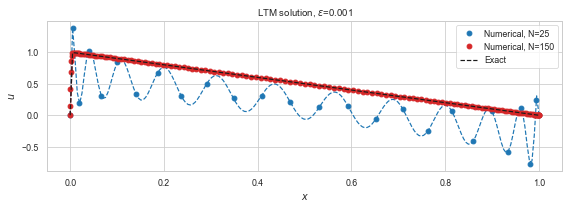

In [123]:
eps = 0.001

a_coeff, b_coeff, c_coeff = -4 * eps, -2, 0

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [25, 150]

colors = ['tab:blue', 'tab:red']

for (i,N) in enumerate(Ns):
    ##### Find uhat by solving system #####
    _, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

    Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
    x_eval = 1/2 * (z+1)

    u_compute = uhat @ Phi

    ##### Plot #####
    x_plot = np.linspace(x0, xN, 200, endpoint=True)
    z_plot = 2 * x_plot - 1
    Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])

    u_plot = uhat @ Phi

    ax.plot(x_eval, u_compute, "o", color=colors[i], label = f"Numerical, N={N}")
    ax.plot(x_plot, u_plot, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LTM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_eps0001.png", dpi=EXPORT_DPI, bbox_inches='tight')

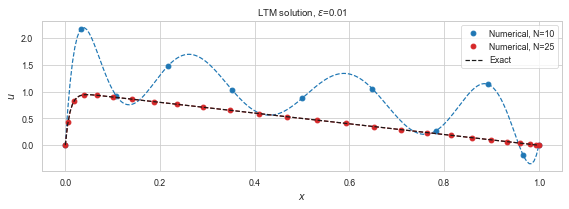

In [124]:
eps = 0.01

a_coeff = -4 * eps

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [10, 25]

colors = ['tab:blue', 'tab:red']

for (i,N) in enumerate(Ns):
    ##### Find uhat by solving system #####
    _, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

    Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
    x_eval = 1/2 * (z+1)

    u_compute = uhat @ Phi

    ##### Plot #####
    x_plot = np.linspace(x0, xN, 200, endpoint=True)
    z_plot = 2 * x_plot - 1
    Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])

    u_plot = uhat @ Phi

    ax.plot(x_eval, u_compute, "o", color=colors[i], label = f"Numerical, N={N}")
    ax.plot(x_plot, u_plot, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LTM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_eps001.png", dpi=EXPORT_DPI, bbox_inches='tight')

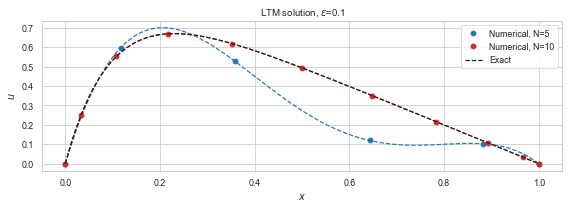

In [125]:
eps = 0.1

a_coeff = -4 * eps

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [5, 10]

colors = ['tab:blue', 'tab:red']

for (i,N) in enumerate(Ns):
    ##### Find uhat by solving system #####
    _, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

    Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
    x_eval = 1/2 * (z+1)

    u_compute = uhat @ Phi

    ##### Interpolation #####
    x_plot = np.linspace(x0, xN, 200, endpoint=True)
    z_plot = 2 * x_plot - 1
    Phi = np.vstack([JacobiP(z_plot, 0, 0, k) for k in range(N)])
    u_plot = uhat @ Phi

    ax.plot(x_eval, u_compute, "o", color=colors[i], label = f"Numerical, N={N}")
    ax.plot(x_plot, u_plot, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LTM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_eps01.png", dpi=EXPORT_DPI, bbox_inches='tight')

In [126]:
##### Calculate errors #####
N_grids = np.arange(5, 200, 1, dtype=int)
errors = np.zeros((len(eps_vec), len(N_grids)), dtype=float)

jacobian = (b-a)/2.0

for (i, eps) in enumerate(eps_vec):
    a_coeff = - 4 * eps
    for (j, N) in enumerate(N_grids):
        w, z, uhat = Tau_Legendre(a_coeff, b_coeff, c_coeff, g0, gN, N)

        Phi = np.vstack([JacobiP(z, 0, 0, k) for k in range(N)])
        x_eval = 1/2 * (z+1)

        u_compute = uhat @ Phi

        u_ex = uexact(x_eval, eps)

        # errors[i, j] = np.linalg.norm(u_compute-u_ex) / np.linalg.norm(u_ex)

        error = u_compute - u_ex
        absolute_error = np.sqrt(np.sum((error ** 2) * jacobian * w))
        norm_true_solution = np.sqrt(np.sum((u_ex ** 2) * jacobian * w))
        errors[i, j] = absolute_error / norm_true_solution


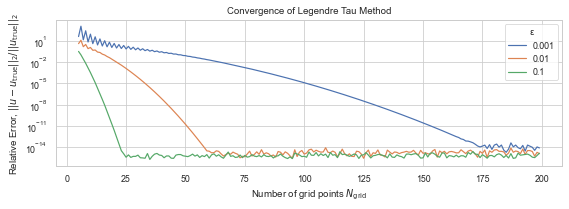

In [127]:
##### Plot error #####
fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

for (i, eps) in enumerate(eps_vec):
    ax.plot(N_grids, errors[i], "-", label=rf"{eps}")

ax.set_yscale('log')
ax.legend()
ax.set_title("Convergence of Legendre Tau Method")
ax.set_xlabel("Number of grid points $N_\\text{grid}$")
ax.set_ylabel("Relative Error, $||u - u_{\\mathrm{true}}||_2 / ||u_{\\mathrm{true}}||_2$")
sns.move_legend(ax, loc="best", title="ε")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_tau_convergence.png", dpi=EXPORT_DPI, bbox_inches='tight')

#### Collocation

In [128]:
# Basis parameters
alpha = 0.0
beta = 0.0
basis_func = partial(jacobi_polynomial_normalised, alpha=alpha, beta=beta)
basic_func_grad = partial(grad_jacobi_polynomial_normalised, k=1, alpha=alpha, beta=beta)

def Collocation_legendre(N, epsilon):

    z_gl, w_gl = jacobi_gauss_lobatto(N, alpha, beta)  # Includes boundaries, domain: [-1, 1]
    # Uncomment to try equidistant grid
    # z_gl = np.linspace(-1, 1, N_grid)
    # w_gl = np.ones_like(z_gl) * 2.0 / (N_grid - 1)

    x_gl = 0.5 * (b - a) * (z_gl + 1) + a  # Map to [a, b]

    # Construct differentiation matrix
    V = construct_vandermonde(z_gl, N + 1, basis_func)
    V_z = construct_vandermonde(z_gl, N + 1, basic_func_grad)
    D_z = np.linalg.solve(
        V.T, V_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

    A = -4.0 * epsilon * np.eye(N + 1)
    B = -2.0 * np.eye(N + 1)
    C = np.zeros((N + 1, N + 1))

    # Set up approximate operator
    L_N = D_z @ A @ D_z + B @ D_z + C

    # RHS
    F = np.ones(N + 1)

    # Enforce BCs
    L_N[0, :] = 0.0
    L_N[0, 0] = 1.0
    L_N[-1, :] = 0.0
    L_N[-1, -1] = 1.0
    F[0] = 0.0
    F[-1] = 0.0

    # Solve
    u_gl = np.linalg.solve(L_N, F)

    return x_gl, z_gl, u_gl, V

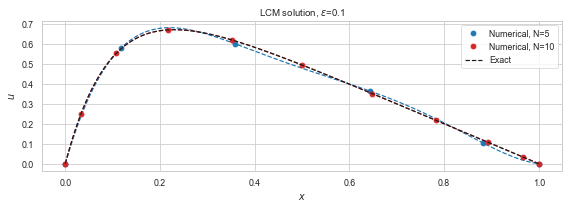

In [129]:
eps = 0.1

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [5, 10]

colors = ['tab:blue', 'tab:red']
for (i, N) in enumerate(Ns):
    x_gl, z_gl, u_gl, V = Collocation_legendre(N, eps)
    # Compute interpolated solution
    N_interp = 1000
    z_gl_interp = np.linspace(-1, 1, N_interp)
    x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
    V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
    I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
    u_interp = I_n @ u_gl

    plt.plot(x_gl, u_gl, "o", color=colors[i], label=f"Numerical, N={N}")
    plt.plot(x_gl_interp, u_interp, "--", color=colors[i])
    plt.legend()

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LCM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_col_eps01.png", dpi=EXPORT_DPI, bbox_inches='tight')

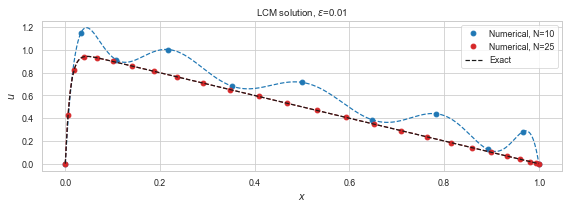

In [130]:
eps = 0.01

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [10, 25]

colors = ['tab:blue', 'tab:red']
for (i, N) in enumerate(Ns):
    x_gl, z_gl, u_gl, V = Collocation_legendre(N, eps)
    # Compute interpolated solution
    N_interp = 1000
    z_gl_interp = np.linspace(-1, 1, N_interp)
    x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
    V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
    I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
    u_interp = I_n @ u_gl

    plt.plot(x_gl, u_gl, "o", color=colors[i], label=f"Numerical, N={N}")
    plt.plot(x_gl_interp, u_interp, "--", color=colors[i])
    plt.legend()

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LCM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_col_eps001.png", dpi=EXPORT_DPI, bbox_inches='tight')

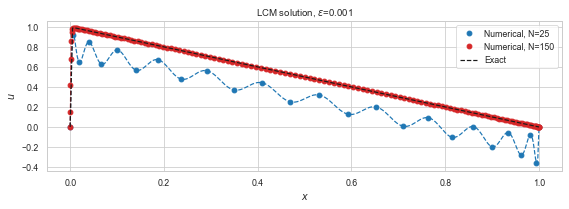

In [136]:
eps = 0.001

fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))

Ns = [25, 150]

colors = ['tab:blue', 'tab:red']
for (i, N) in enumerate(Ns):
    x_gl, z_gl, u_gl, V = Collocation_legendre(N, eps)
    # Compute interpolated solution
    N_interp = 400
    z_gl_interp = np.linspace(-1, 1, N_interp)
    x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
    V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
    I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
    u_interp = I_n @ u_gl

    ax.plot(x_gl, u_gl, "o", color=colors[i], label=f"Numerical, N={N}")
    ax.plot(x_gl_interp, u_interp, "--", color=colors[i])

ax.plot(x_plot, uexact(x_plot, eps), 'k--', label = "Exact")
ax.legend()
ax.set_title(rf"LCM solution, $\varepsilon$={eps}")
ax.set_xlabel(f"$x$")
ax.set_ylabel("$u$")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_col_eps0001.png", dpi=EXPORT_DPI, bbox_inches='tight')

In [132]:
# Basis parameters
alpha = 0.0
beta = 0.0

use_normalised = False
if use_normalised:
    basis_func = partial(jacobi_polynomial_normalised, alpha=alpha, beta=beta)
    basic_func_grad = partial(
        grad_jacobi_polynomial_normalised, k=1, alpha=alpha, beta=beta
    )
else:
    basis_func = partial(jacobi_polynomial, alpha=alpha, beta=beta)
    basic_func_grad = partial(
        grad_jacobi_polynomial, alpha=alpha, beta=beta
    )

def u_func_1(x, epsilon):
    denom = np.exp(-1.0 / epsilon) - 1
    nom = +np.exp(-x / epsilon) + (x - 1) - np.exp(-1 / epsilon) * x
    return nom / denom

epsilons = [0.1, 0.01, 0.001]
N_grids = np.arange(5, 200, 1, dtype=int)
data = []
for epsilon, N_grid in itertools.product(epsilons, N_grids):
    N = N_grid - 1  # Highest polynomial order

    z_gl, w_gl = jacobi_gauss_lobatto(N, alpha, beta)  # Includes boundaries, domain: [-1, 1]
    # Uncomment to try equidistant grid
    # z_gl = np.linspace(-1, 1, N_grid)
    # w_gl = np.ones_like(z_gl) * 2.0 / (N_grid - 1)

    jacobian = (b-a)/2.0
    x_gl = jacobian * (z_gl + 1) + a  # Map to [a, b]
    u_gl_true = u_func_1(x_gl, epsilon)

    # Construct differentiation matrix
    V = construct_vandermonde(z_gl, N + 1, basis_func)
    V_z = construct_vandermonde(z_gl, N + 1, basic_func_grad)
    D_z = np.linalg.solve(
        V.T, V_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve
    A = -4.0 * epsilon * np.eye(N + 1)
    B = -2.0 * np.eye(N + 1)
    C = np.zeros((N + 1, N + 1))

    # Better numerics at cost of less generality
    D_z2 = D_z @ D_z
    a_coeff = -4.0 * epsilon
    b_coeff = -2.0
    c_coeff = 0.0

    # Set up approximate operator
    L_N = a_coeff * D_z2 + b_coeff * D_z + c_coeff

    # RHS
    F = np.ones(N + 1)

    # Enforce BCs
    L_N[0, :] = 0.0
    L_N[0, 0] = 1.0
    L_N[-1, :] = 0.0
    L_N[-1, -1] = 1.0
    F[0] = 0.0
    F[-1] = 0.0

    # Solve
    u_gl = np.linalg.solve(L_N, F)

    # Compute accuracy as L2 norm
    # See Kopriva 1.131
    errors = u_gl - u_gl_true
    absolute_error = np.sqrt(np.sum((errors ** 2) * jacobian * w_gl))
    norm_true_solution = np.sqrt(np.sum((u_gl_true ** 2) * jacobian * w_gl))
    relative_error = absolute_error / norm_true_solution

    naive_norm_error = np.linalg.norm(u_gl - u_gl_true, ord=2)

    data.append({
        "N_grid": N_grid,
        "epsilon": epsilon,
        "naive_norm_error": naive_norm_error,
        "relative_error": relative_error,
    })

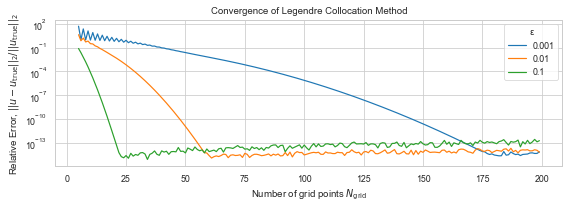

In [133]:
# For report
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))
sns.lineplot(data=df, x="N_grid", y="relative_error", hue="epsilon", palette="tab10")
plt.semilogy()

plt.title("Convergence of Legendre Collocation Method")
plt.xlabel("Number of grid points $N_\\text{grid}$")
plt.ylabel("Relative Error, $||u - u_{\\mathrm{true}}||_2 / ||u_{\\mathrm{true}}||_2$")
sns.move_legend(ax, loc="best", title="ε")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_collocation_convergence.png", dpi=EXPORT_DPI, bbox_inches='tight')